**Summed orderbook probability**

**Reference:** ORDERBOOK-PROBABILITY.ipynb notebook in exocharts github

**Description:** So far calculating the probability of price going up only using lvl 1 orderbook proved to be mediocre strategy, it needs expansions and experimentation to find the best possible value from the given integral formula. This notebook explores what happens if we sum first 25 levels of orderbook and then calculate the probability

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import scipy.integrate as spi
import matplotlib.pyplot as plt
options={'limit':10000000}
history = {}

def calc_integral(bidvol, askvol):
    if (bidvol, askvol) in history:
        return history[(bidvol, askvol)]
    integrand = lambda t :((2 - np.cos(t) - np.sqrt( (2-np.cos(t))**2 - 1 ))**askvol)*np.sin(bidvol*t)*np.cos(t/2)/np.sin(t/2)
    a = 0.
    b = np.pi
    result, error = spi.nquad(integrand, [[a, b]], opts=options)
    history[(bidvol, askvol)]  = result/np.pi
    return history[(bidvol, askvol)]

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
d = pd.read_csv("bitmex_book_snapshot_25_2020-09-01_XBTUSD.csv", nrows = 10000)
d = d[[i for i in d.columns if 'amount' in i]]

In [15]:
d

,sumasks,sumbids
0,4204693,8409386
1,4190689,8381378
2,4190689,8381378
3,4190889,8381778
4,4190881,8381762
...,...,...
9995,5061278,10122556
9996,5068286,10136572
9997,5068286,10136572
9998,5068286,10136572


### Summing bids and asks for 25 levels

In [5]:
d["sumasks"] = d[[i for i in d.columns if 'asks' in i]].sum(axis = 1)
d["sumbids"] = d[[i for i in d.columns if 'asks' in i]].sum(axis = 1)
d = d[["sumasks", "sumbids"]]

### No transformation

In [6]:
done = d.copy()

In [7]:
pone = done.progress_apply(lambda row: calc_integral(row['sumbids'],row['sumasks']), axis = 1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 11734.82it/s]


<AxesSubplot:>

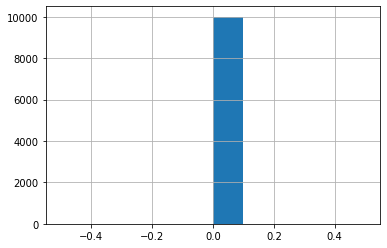

In [8]:
pone.hist(bins = 10)

### Standartization

In [9]:
dtwo = (d - d.mean())/d.std()
dtwo

,sumasks,sumbids
0,0.192287,0.192287
1,0.184267,0.184267
2,0.184267,0.184267
3,0.184381,0.184381
4,0.184377,0.184377
...,...,...
9995,0.682862,0.682862
9996,0.686875,0.686875
9997,0.686875,0.686875
9998,0.686875,0.686875


In [10]:
ptwo = dtwo.progress_apply(lambda row: calc_integral(row['sumbids'],row['sumasks']), axis = 1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12016.41it/s]


<AxesSubplot:>

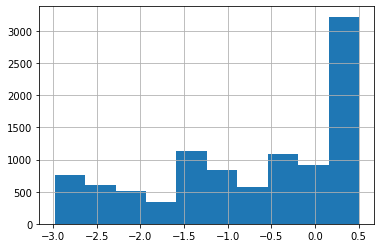

In [11]:
ptwo.hist(bins = 10)

### Normalization

In [12]:
dthree = (d - d.min())/(d.max() - d.min())
dthree

,sumasks,sumbids
0,0.390007,0.390007
1,0.388065,0.388065
2,0.388065,0.388065
3,0.388092,0.388092
4,0.388091,0.388091
...,...,...
9995,0.508824,0.508824
9996,0.509796,0.509796
9997,0.509796,0.509796
9998,0.509796,0.509796


In [13]:
pthree = dthree.progress_apply(lambda row: calc_integral(row['sumbids'],row['sumasks']), axis = 1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12339.36it/s]


<AxesSubplot:>

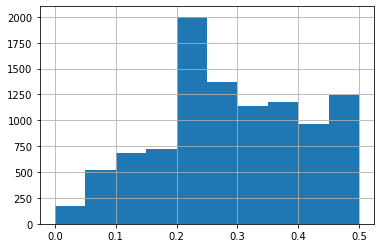

In [14]:
pthree.hist(bins = 10)

**Conclusion:** it seems with the given numbers, the intergral gives nonsense probabilitys as every result should be in the range of [0;1]. Also I explore how the probabilities change if we standartize or normalize the data before calculation. None of the methods except normalization to range 0->1 provided correct probabilities.